In [1]:
"""
Art Generation with Neural Style Transfer (NST):
The steps implemented in this code are as follows:

1. Visualize the content and style image
2. Select model for transfer learning (e.g., the VGG19)
3. Resize the content and style image to desired input shape
3. Randomly initialize the image to be generated
4. Build and train the model
    1. Build the model
    2. Compute the costs: content, style, and total cost
    3. Define the optimizer and learning rate
    7. Train the model
5. Test with your picture
"""

from utils_nst import *
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import pprint

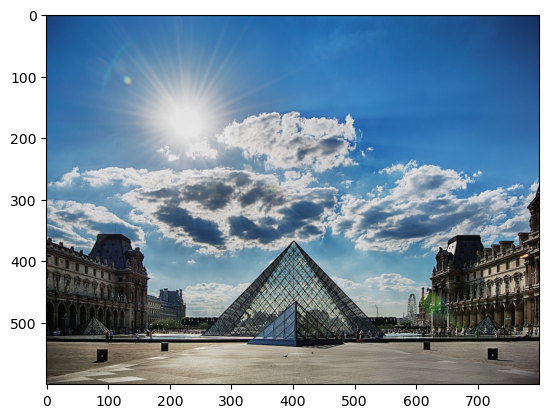

In [3]:
# VISUALIZE CONTENT AND STYLE IMAGE
# Content image
content_image = Image.open(os.path.join(os.getcwd(), 'images', 'louvre.jpg'))
imshow(content_image)
plt.show()

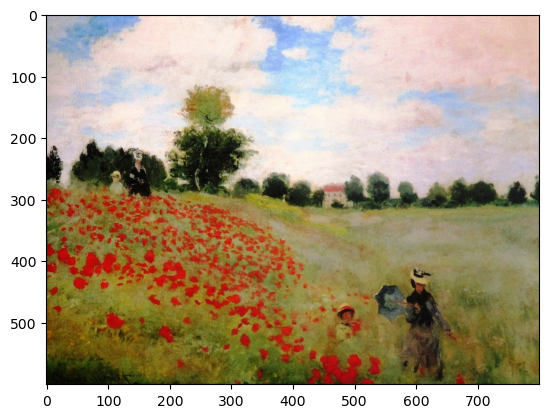

In [4]:
# Style image
style_image = Image.open(os.path.join(os.getcwd(), 'images', 'style_monet_800600.jpg'))
imshow(style_image)
plt.show()

In [5]:
# SELECT VGG19: THE PRETRAINED MODEL FOR TRANSFER LEARNING
tf.random.set_seed(42)
img_size = 400
weight_path = os.path.join(os.getcwd(), 'pretrained-model', 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False

<Functional name=vgg19, built=True>


In [6]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 400, 400, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 400, 400, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 200, 200, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 200, 200, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 100, 100, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 50, 50, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 25, 25, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
# RESIZE CONTENT AND STYLE IMAGES
content_image = np.array(content_image.resize((img_size, img_size)))
mod_shape = (1,) + content_image.shape
content_image = tf.constant(np.reshape(content_image, mod_shape))
content_image.shape

TensorShape([1, 400, 400, 3])

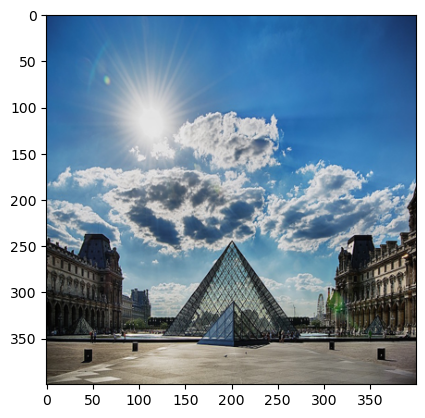

In [8]:
imshow(content_image[0])
plt.show()

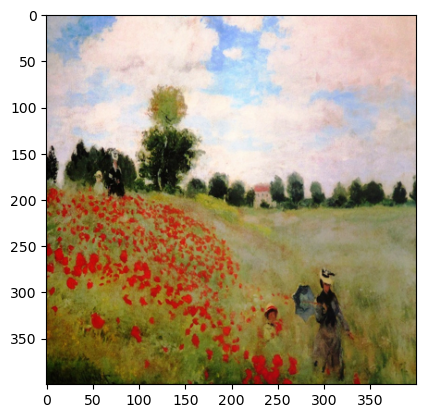

In [9]:
style_image = np.array(style_image.resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, mod_shape))
imshow(style_image[0])
plt.show()

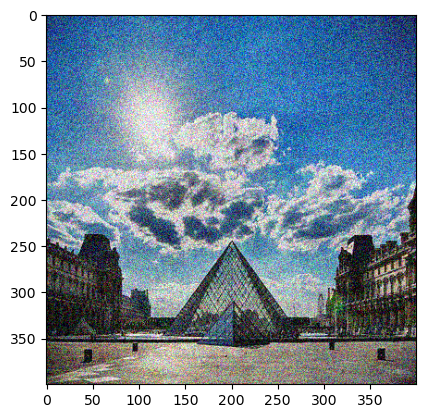

In [10]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(shape=tf.shape(generated_image), minval=-0.25, maxval=0.25)  # Noise data
generated_image = tf.add(generated_image, noise)  # Adding the noise to the image
generated_image = clip_values_0_1(generated_image)  # Clips tensor values to be between 0 and 1
imshow(generated_image.numpy()[0])
plt.show()

In [19]:
# BUILD MODEL FROM PRE-TRAINED VGG19
def get_layers_outputs(base_model, layer_names):
    """
    Creates a model that returns a list of intermediate layer outputs from the given base model.

    Arguments:
        base_model -- Pre-trained model.
        layer_names -- List of strings, names of the layers whose outputs are desired.

    Returns:
        model -- A new model that outputs the intermediate values of the specified layers.
    """
    # Extract the outputs of the specified layers
    outputs = [base_model.get_layer(layer_info[0]).output for layer_info in layer_names]

    # Create a new model that takes the same input as the original model and outputs the specified layers
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

In [20]:
# Select the layers to represent the style of the image and assign style costs
# Adding weights for each layer to balance their influence on the final style output
Selected_Style_Layers = [('block1_conv1', 0.2),
                         ('block2_conv1', 0.2),
                         ('block3_conv1', 0.2),
                         ('block4_conv1', 0.2),
                         ('block5_conv1', 0.2)]

content_layer = [('block5_conv4', 1)]

In [21]:
vgg_model_outputs = get_layers_outputs(vgg, Selected_Style_Layers + content_layer)

# Save the encoding of the content and style images in a separate variable
content_target = vgg_model_outputs(content_image)  # Content
style_targets = vgg_model_outputs(style_image)     # Style

In [25]:
# TRAIN THE MODEL
# a_C is the content image encoding for layer "block5_conv4"
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# a_S is the style image encoding for layers specified in Selected_Style_Layers.
preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [33]:
@tf.function
def train_step(gen_image):
    """
    Performs a single training step for updating the generated image to minimize the style and content costs.

    Arguments:
        gen_image -- TensorFlow variable representing the generated image.

    Returns:
        J -- Tensor representing the total cost after the training step.
    """
    with tf.GradientTape() as tape:
        # a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(gen_image)

        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G, style_layers=Selected_Style_Layers)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)

        # Compute the total cost
        J = total_cost(J_content, J_style, alpha=10, beta=40)  # i.e., 1:4 ratio
        # J = total_cost(J_content, J_style, alpha=1, beta=10000)  # Original paper scale is 1:1000 and 1:10000

    # Compute gradients of the total cost with respect to the generated image
    grad = tape.gradient(J, gen_image)

    # Apply gradients to the optimizer to update the generated image
    optimizer.apply_gradients([(grad, gen_image)])

    clipped_image = clip_values_0_1(gen_image)
    generated_image.assign(clipped_image)  # Update the generated image with the clipped values

    return J

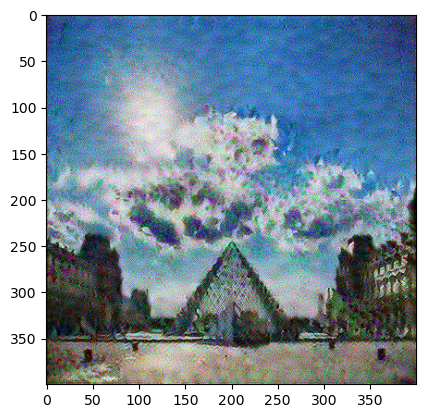

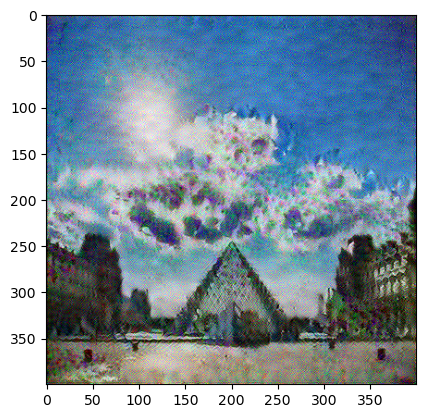

In [36]:
generated_image = tf.Variable(generated_image)  # Initialized as a tf.Variable since it needs to be trainable
epochs = 200
J_hist = []

for i in range(epochs):
    cost = train_step(generated_image)
    J_hist.append(cost)

    if i % 100 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)

        output_dir = os.path.join(os.getcwd(), 'outputs')
        os.makedirs(output_dir, exist_ok=True)
        image.save(os.path.join(output_dir, f"image_{i}.jpg"))
        plt.show()

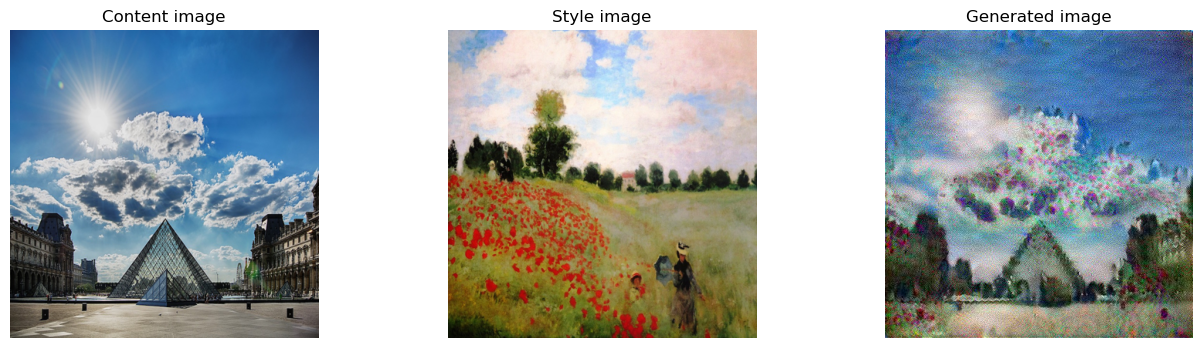

In [38]:
# Training takes time. You can see some of the images generated in the output folder.
gen_image = plt.imread(os.path.join(os.getcwd(), 'outputs', 'image_2500.jpg'))
# See all three images in a row
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
images = [content_image[0], style_image[0], np.array(gen_image)]
titles = ['Content image', 'Style image', 'Generated image']

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

plt.show()